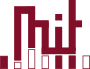 Mesterséges Intelligencia és Rendszertervezés Tanszék, ©2024-2025. BME-MIT, Vetró Mihály, Révy Gábor, Dr. Hullám Gábor  

# **VIMIMB10 - Megbízható Mesterséges Intelligencia és Adatelemzés**
## 2025. Tavaszi félév
## **5. Laborgyakorlat - Magyarázatgenerálás black-box modellekhez az Adult Census Income adathalmazon**

Ezen a gyakorlaton arra látunk majd példát, hogy hogyan lehet alkalmazni magyarázó eljárásokat (nevezetesen a LIME és a Shapley-mintavételezést), hogy magyarázatot adjunk az egyébként nehezen magyarázható modellek predikcióira.


Ehhez először telepítsük a magyarázó technikákhoz szükséges könyvtárakat:

In [ ]:
%%capture

!pip install lime
!pip install shap

Importáljuk a szükséges könyvtárakat:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Adathalmaz betöltése és előkészítése

Adjuk meg az adatok elérési útját a kari szerveren:


(az adatok és jellemzőinek további leírása [az adathalmaz oldalán](https://archive.ics.uci.edu/dataset/2/adult) található).

In [ ]:
csv_path = 'https://share.mit.bme.hu/index.php/s/NMREEm4KCRgeCFX/download/adult_reconstruction.csv'

Határozzuk meg a jellemzők típusát (folytonos vagy kategorikus), és töltsük be az adatokat:

In [ ]:
continuous_features_L = [
    "hours-per-week",
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
]

categorical_features_L = [
    "workclass",
    "marital-status",
    "relationship",
    "race",
    "gender",
    "native-country",
    "occupation",
]

df = pd.read_csv(csv_path)
df

Nézzünk meg néhány alapvető jellemzőt a betöltött adatokról:

In [ ]:
df.describe()

In [ ]:
df.hist(bins=20)
plt.tight_layout()
plt.show();

Mivel az iskolai végzettséget alapértelmezés szerint numerikus formátumban adjuk meg (`education-num`), a kategorikus `education` változó felesleges, és eltávolítható:

In [ ]:
df.drop(['education'], axis=1, inplace=True)

Ezután numerikusan kódoljuk a kategorikus változókat. Érdemes megjegyezni, hogy ez nem szükséges, és csak technikai okokból tesszük. Később az összes kategorikus változót átalakítjuk one-hot kódolású változókká.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for c in categorical_features_L:
  le = LabelEncoder()
  label_encoders[c] = le
  df[c] = le.fit_transform(df[c])

df.head()

In [ ]:
df.describe()

In [ ]:
df.hist(figsize=(10, 7), bins=20)
plt.tight_layout()
plt.show();

Megőrizzük az eredeti kategórianeveket is minden jellemzőhöz egy külön dictionary-ben:

In [ ]:
feature_class_names = {}

for c in categorical_features_L:
  feature_class_names[c] = label_encoders[c].classes_

Binarizáljuk a célváltozót (a háztartások éves jövedelme (`income`) 1992-ben) \$$50000$-nál, hogy magas és alacsony jövedelmű háztartások közötti osztályozási feladatot végezhessünk, majd osszuk fel az adathalmazt tanító és teszt partíciókra:

In [ ]:
from sklearn.model_selection import train_test_split

input_data = df.drop(['income'], axis=1)
label_data = df['income'] > 50000

x_train, x_test, y_train, y_test = train_test_split(input_data, label_data, test_size=0.3, random_state=42)
x_train.shape, x_test.shape

Implementáljuk a kategorikus jellemzők one-hot enkódolását:

In [ ]:
import sklearn
from sklearn.compose import ColumnTransformer

one_hot_encoder = sklearn.preprocessing.OneHotEncoder()
encoder = ColumnTransformer(
    transformers=[
        ("cat", one_hot_encoder, categorical_features_L),
    ])
encoder.fit(input_data)  # fit encoding for the whole dataset

In [ ]:
x_train_encoded = encoder.transform(x_train)
x_test_encoded = encoder.transform(x_test)

x_train_encoded = np.c_[x_train[continuous_features_L].values, x_train_encoded.toarray()]
x_test_encoded = np.c_[x_test[continuous_features_L].values, x_test_encoded.toarray()]

# Random forest osztályozó tanítása és vizsgálata

Az első black-box modell, amelyet megvizsgálunk, egy véletlen erdő osztályozó (Random Forest Classifier - RFC), amely összesen $100$ döntési fát tartalmaz.


Ehhez létrehozzuk és betanítjuk az RFC-t az előfeldolgozott adatokon:

In [ ]:
import sklearn.ensemble

rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=0)
rfc.fit(x_train_encoded, y_train)

Ezután megmérjük a pontosságot a tanító és teszt partíciókon:

In [ ]:
accuracy_train = np.mean(y_train == rfc.predict(x_train_encoded))
accuracy_test = np.mean(y_test == rfc.predict(x_test_encoded))
print(f'Accuracy train: {accuracy_train:.4f}')
print(f'Accuracy test:  {accuracy_test:.4f}')

Ezután a jellemző (feature) és a jellemző-kategória neveket külön változókba exportáljuk:

In [ ]:
feature_names = input_data.columns.tolist()
categorical_features = [i for i, n in enumerate(input_data.columns)
                            if n in categorical_features_L]
categorical_names = {i: dict(enumerate(feature_class_names[feature_names[i]])) for i in categorical_features}

Továbbá, a transzformált (one-hot) reprezentációhoz hozzárendeljük a jellemzők neveit is, hogy az egyes jellemzők fontosságát ábrázolni tudjuk.

In [ ]:
onehot_feature_names = continuous_features_L.copy()
for i in range(len(feature_names)):
  if i in categorical_names.keys():
    for val_key in sorted(categorical_names[i].keys()):
      onehot_feature_names.append(f"{feature_names[i]}={categorical_names[i][val_key]}")

Ezután megvizsgáljuk a jellemzők fontosságát a random forest osztályozó struktúrája alapján. Ebben az esetben az átlagos jellemző fontosságot úgy definiáljuk, mint a Gini-index (impurity) értékének átlagos csökkenése, amikor az adatokat az adott jellemző mentén osztjuk fel. Alapértelmezés szerint ennek mérőszáma a `RandomForestClassifier` modellben a [gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity).

A következő két cellában kinyerjük és ábrázoljuk minden jellemző átlagos fontosságát, valamint a jellemzők fontosságának szórását a random forest egyes döntési fái között:

In [ ]:
importance_mean = rfc.feature_importances_
importance_std = np.std(np.array([tree.feature_importances_ for tree in rfc.estimators_]), axis=0)

In [ ]:
plt.figure(figsize=(20, 5))
plt.bar(onehot_feature_names, importance_mean, yerr=importance_std)
plt.xticks(rotation=90)
plt.show();

Amint az eredményekből látható, a legtöbb folytonos jellemző, mint például a "kor" (`age`), a "végzettség" (`education-num`) és a "tőkenyereség" (`capital-gain`) következetesen nagy jelentőséggel bírnak, míg a legtöbb diszkrét jellemzőnek alacsony a jelentősége. Érdemes azonban megjegyezni, hogy egyes diszkrét jellemző-érték párok az egyes fáktól függően nagy jelentőséggel bírhatnak, ezért nem szabad őket elvetni.

### LIME

Elsőként vizsgáljuk meg a Local Interpretable Model-Agnostic Explanations (röviden LIME) magyarázó módszert.

Ezen módszer működését röviden az alábbi lépéssor foglalja össze:

1. Mintavételezzük a bemeneti teret a magyarázni kívánt bemenet körül (pl. a bemenethez társított véletlenszerű additív zaj segítségével)
2. Rögzítsük a modell predikcióit a mintavételezett pontokra.
3. Illesszünk egy egyszerű (jellemzően lineáris) modellt az így kapott bemenet-kimenet párokra úgy, hogy a modell elkészítése során a mintákat az eredeti (magyarázni kívánt) bemenettől való távolság inverzével súlyozzuk.
4. Az így kapott egyszerű modell magyarázható, és a vizsgált bemenet környezetében feltehetően jól imitálja az eredeti modell viselkedését, tehát illeszkedik a döntési felületre. Az egyszerű modell paramétereiből megállapíthatjuk az egyes bemenetek szerepét az osztályozó döntésének kialakításában.

A fent prezentált lépéssor első három elemét az alábbi ábra foglalja össze:

![LIME image](https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png)

Ahol a magyarázni kívánt minta piros kereszttel, a bemeneti térből vett minták keresztekkel és körökkel, az eredeti modell döntési felületét a háttér színezésével, a mintákra illesztett magyarázható (lineáris) modell döntési felületét pedig szaggatott vonallal jelölték.

A LIME módszer részletes leírása a [kapcsolódó publikációban](https://arxiv.org/pdf/1602.04938v3.pdf) fellelhető.

> Összefoglalva tehát a LIME módszer pusztán a bemenetek, és a modell azokra adott válasza alapján definiál egy magyarázható modellt, amely közelíti a magyarázandó modell viselkedését a bemenet környezetében. Mivel a LIME nem követel meg semmilyen feltételezést a magyarázandó modell belső működésével kapcsolatban, így bármilyen prediktív modell kimenetének magyarázására felhasználható, tehát modellfüggetlen módszer.

Importáljuk és definiáljuk a LIME magyarázót a modellünkhöz:

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_tabular.LimeTabularExplainer
rfc_explainer_lime = lime.lime_tabular.LimeTabularExplainer(x_train.to_numpy(), mode='classification',
                                                       feature_names=feature_names,
                                                       categorical_features=categorical_features,
                                                       categorical_names=categorical_names,
                                                       class_names=['below 50K $', 'above 50K$'],
                                                       kernel_width=3,
                                                       verbose=True)

Ezután definiáljuk a prediktor függvényt, amely a LIME keretrendszerhez szükséges:

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def pred_func_rfc(x):
  x = pd.DataFrame(x, columns=feature_names)
  x_transformed = encoder.transform(x)
  return rfc.predict_proba(np.c_[x[continuous_features_L].values, x_transformed.toarray()])

Ezután egyetlen bemenethez magyarázatot generálunk. Az egyes bemeneti jellemzők hatásának nagyságát és irányát a LIME keretrendszer kvantálja.

In [ ]:
i = 136

inst = x_test.to_numpy()[i]
exp = rfc_explainer_lime.explain_instance(inst, pred_func_rfc, num_features=10, num_samples=10000)
exp.show_in_notebook(show_all=True)

A fenti magyarázatban a végső kimenetet osztályok valószínűségeinek formájában láthatjuk (balra), az egyes jellemzők hatását pedig jobbra és középen. A kékkel jelölt jellemzők a predikciót az alacsonyabb jövedelem irányába, míg a narancssárgával jelölt jellemzők a "50K$ feletti" osztály felé mozdították el.

### Shapley mintavételezés

A Shapley mintavételezés alapgondolata, hogy a modell bemeneti változóit egyesével kicseréljük egy véletlenszerűen választott értékkel, majd megfigyeljük, hogy a kimenet ennek hatására hogyan változik. A mért változás nagysága feltehetően arányos az adott változó kimenetre gyakorolt hatásának nagyságával, iránya pedig a változó hatásának irányára lesz indikatív.

A következőkben a Shapley-féle mintavételi (vagy közismert nevén SHAP) módszert vizsgáljuk ugyanennek az RFC-modellnek a magyarázatára:

In [ ]:
import shap

rfc_explainer_shap = shap.SamplingExplainer(pred_func_rfc, data=shap.sample(x_train, 1000, random_state=42))

A modellmagyarázó definiálása után kiszámítjuk a SHAP értékeket, amelyek az egyes hatások közelítéseiként szolgálnak.

In [ ]:
rfc_shap_values = rfc_explainer_shap.shap_values(x_test.iloc[:200, :], nsamples=1000, random_state=42)

Majd magyarázatot generálunk egyetlen bemenetre:

In [ ]:
index_to_explain = 136

shap.initjs()
shap.force_plot(rfc_explainer_shap.expected_value[1], rfc_shap_values[index_to_explain, :, 1], x_test.iloc[index_to_explain, :])

Emellett az adatok egy nagyobb részéhez is készíthetünk  magyarázatokat, és elemezhetjük az eredményeket.


A következő cellában rajdiagramon (swarm plot) ábrázoljuk minden egyes mintára az egyes jellemzők hatását:

In [ ]:
shap.summary_plot(rfc_shap_values[:, :, 1], x_test.iloc[:200, :], feature_names=x_test.columns)

A jellemzők együttes hatása egy összetett vonaldiagramon figyelhető meg:


(a kékkel jelölt jellemzők negatív irányban befolyásolják a kimenetet, míg a pirossal jelölt jellemzők ellentétes hatást fejtenek ki).

In [ ]:
shap.initjs()
shap.force_plot(
    rfc_explainer_shap.expected_value[1], rfc_shap_values[:, :, 1], x_test.iloc[:200, :]
)

# Neurális hálózat betanítása és magyarázata

Ebben a részben egy nagyon hasonló magyarázó folyamatot hajtunk végre ugyanazon a feladaton, de most egy egyszerű neurális hálózatot használunk a magyarázandó prediktív modellként.


Ehhez importáljuk a TensorFlow könyvtárat, majd létrehozzuk és betanítjuk a neurális hálózati modellt:

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model_path = "class_model_dense.keras"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         mode="max",
                                                         verbose=1)

model.fit(x=x_train_encoded, y=y_train.astype(np.float32),
          validation_split=0.2,
          shuffle=True,
          batch_size=64,
          # class_weight={0: 0.25, 1: 0.75},
          epochs=50,
          callbacks=[checkpoint_callback])

Tanítás után töltsük be a validációs készleten legjobban teljesítő modellt, és nézzük meg a pontosságot:

In [ ]:
model.load_weights(model_path)

accuracy_train = np.mean(y_train == np.round(model.predict(x_train_encoded, verbose=0).flatten()))
accuracy_test = np.mean(y_test == np.round(model.predict(x_test_encoded, verbose=0).flatten()))
print(f'Accuracy train: {accuracy_train:.4f}')
print(f'Accuracy test:  {accuracy_test:.4f}')

### LIME

Ezután végezzük el ugyanazokat a magyarázó lépéseket a LIME-mal, mint az RFC osztályozó esetében:

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_tabular.LimeTabularExplainer
nn_explainer_lime = lime.lime_tabular.LimeTabularExplainer(x_train.to_numpy(), mode='classification',
                                                           feature_names=feature_names,
                                                           categorical_features=categorical_features,
                                                           categorical_names=categorical_names,
                                                           class_names=['below 50K $', 'above 50K$'],
                                                           kernel_width=3,
                                                           verbose=True)

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def pred_func_nn(x):
  x = pd.DataFrame(x, columns=feature_names)
  x_transformed = encoder.transform(x)
  pred = model.predict(np.c_[x[continuous_features_L].values, x_transformed.toarray()],
                       verbose=0)
  res = np.hstack([1-pred, pred])
  return res

In [ ]:
i = 136

inst = x_test.to_numpy()[i]
exp = nn_explainer_lime.explain_instance(inst, pred_func_nn, num_features=10, num_samples=10000)
exp.show_in_notebook(show_all=True)

### SHAP

És hasonlóan a SHAP lépéseket is (ezúttal `SamplingExplainer` nevű módszert alkalmazva):

In [ ]:
import shap

nn_explainer_shap = shap.SamplingExplainer(pred_func_nn, shap.sample(x_train, 1000, random_state=42))

A SHAP-értékek kiszámítása néhány percet igénybe vehet:

In [ ]:
nn_shap_values = nn_explainer_shap.shap_values(x_test.iloc[:200, :], nsamples=1000, random_state=42)

In [ ]:
index_to_plot = 136

shap.initjs()
shap.force_plot(nn_explainer_shap.expected_value[1], nn_shap_values[index_to_plot, :, 1], x_test.iloc[index_to_plot, :], feature_names=x_test.columns)

In [ ]:
shap.summary_plot(nn_shap_values[:, :, 1], x_test.iloc[:200, :], feature_names=x_test.columns)

In [ ]:
shap.initjs()
shap.force_plot(
    nn_explainer_shap.expected_value[1], nn_shap_values[:200, :, 1], x_test.iloc[:200, :]
)

In [ ]:
def extract_feature_name(fval_string):
    for fname in feature_names:
        if fname in fval_string:
            return fname
    return None

def plot_comparison(index_to_compare):
    rfc_attributions_lime = rfc_explainer_lime.explain_instance(x_test.to_numpy()[index_to_compare], pred_func_rfc, num_features=14, num_samples=10000).as_list()
    nn_attributions_lime = nn_explainer_lime.explain_instance(x_test.to_numpy()[index_to_compare], pred_func_nn, num_features=14, num_samples=10000).as_list()

    plot_df_lime = pd.DataFrame({
        "feature_value": [e[0] for e in rfc_attributions_lime] + [e[0] for e in nn_attributions_lime],
        "model_type": ["RFC"] * len(feature_names) + ["NN"] * len(feature_names),
        "feature_attribution": [e[1] for e in rfc_attributions_lime] + [e[1] for e in nn_attributions_lime]
    })
    plot_df_lime["feature_name"] = plot_df_lime["feature_value"].apply(extract_feature_name)
    plot_df_lime = plot_df_lime.sort_values(by=["feature_name"])

    plot_df_shap = pd.DataFrame({
        "feature_value": [f"{fname}={fval}" for fname, fval in zip(feature_names, x_test.iloc[index_to_compare, :])] * 2,
        "model_type": ["RFC"] * len(feature_names) + ["NN"] * len(feature_names),
        "feature_attribution": np.hstack([rfc_shap_values[index_to_compare, :, 1], nn_shap_values[index_to_compare, :, 1]])
    })
    plot_df_shap["feature_name"] = plot_df_shap["feature_value"].apply(extract_feature_name)
    plot_df_shap = plot_df_shap.sort_values(by=["feature_name"])

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    for ax, plot_df, title in zip(axes, [plot_df_lime, plot_df_shap], ["LIME", "SHAP"]):
        sns.barplot(data=plot_df, y="feature_value", x="feature_attribution", hue="model_type", ax=ax)
        ax.vlines(x=0., ymin=-0.5, ymax=len(feature_names) - 0.5, linestyles="dashed", color="black",
                  transform=ax.get_xaxis_transform())
        ax.hlines(y=np.arange(-0.5, len(feature_names) + 0.5), xmin=-1., xmax=1., color="grey", alpha=0.5,
                  transform=ax.get_yaxis_transform())
        ax.set_title(title)
    axes[0].get_legend().remove()
    plt.tight_layout()
    plt.show()

In [ ]:
index_to_compare = 136

plot_comparison(index_to_compare)